# K-means para arquétipos sonoros
    Pipeline para agrupar faixas do Spotify com base em atributos de áudio, conforme estratégia definida.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import joblib
import os


## 1. Carregamento e limpeza
    - Lê o dataset bruto
    - Remove duplicatas por `track_id`
    - Mantém apenas colunas numéricas de áudio

In [2]:
os.chdir('..')
data_path = Path('./data/raw/SpotifyFeatures.csv')
df = pd.read_csv(data_path)
print(df.shape, df.columns.tolist())

df = df.drop_duplicates(subset=['track_id'])

feature_cols = [
        'danceability', 'energy', 'acousticness', 'speechiness', 'valence',
        'tempo', 'duration_ms', 'instrumentalness', 'liveness', 'loudness'
]

# mantém track_id para deduplicação posterior nas amostras
keep_cols = feature_cols + ['popularity', 'genre', 'track_name', 'artist_name', 'track_id']
df_features = df[keep_cols].copy()
print('Após seleção de colunas:', df_features.shape)


(232725, 18) ['genre', 'artist_name', 'track_name', 'track_id', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
Após seleção de colunas: (176774, 15)


## 2. Pré-processamento
    - `duration_ms`: log1p para reduzir cauda longa
    - Padronização (z-score) em todas as features numéricas
    - Amostra de desenvolvimento para experimentos de K

In [3]:
df_features['duration_ms'] = np.log1p(df_features['duration_ms'])

numeric_cols = feature_cols.copy()
X_numeric = df_features[numeric_cols].dropna()

# amostra para avaliação rápida
sample_size = 50000
sample_df = X_numeric.sample(n=sample_size, random_state=42) if len(X_numeric) > sample_size else X_numeric.copy()

scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(sample_df)


## 3. Busca de K
    - Avalia K em {4, 5, 6, 8, 10, 12}
    - Métricas: inertia (elbow), silhouette, Davies-Bouldin
    - Usa múltiplas seeds para estabilizar resultados

In [4]:
# Ks = [3, 4, 5, 6, 8, 10, 12]
# seeds = [42, 7, 21]
# results = []

# for k in Ks:
#     silhouettes = []
#     dbs = []
#     inertias = []
#     for seed in seeds:
#         km = KMeans(n_clusters=k, n_init=10, random_state=seed, max_iter=500)
#         labels = km.fit_predict(X_sample_scaled)
#         inertias.append(km.inertia_)
#         silhouettes.append(silhouette_score(X_sample_scaled, labels))
#         dbs.append(davies_bouldin_score(X_sample_scaled, labels))
#     results.append({
#         'k': k,
#         'inertia_mean': np.mean(inertias),
#         'silhouette_mean': np.mean(silhouettes),
#         'db_mean': np.mean(dbs)
#     })

# metrics_df = pd.DataFrame(results)
# metrics_df


In [5]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].plot(metrics_df['k'], metrics_df['inertia_mean'], marker='o')
# ax[0].set_title('Elbow (Inertia média)')
# ax[0].set_xlabel('k')
# ax[0].set_ylabel('Inertia')

# ax[1].plot(metrics_df['k'], metrics_df['silhouette_mean'], marker='o', color='green')
# ax[1].set_title('Silhouette média')
# ax[1].set_xlabel('k')
# ax[1].set_ylabel('Silhouette')
# plt.tight_layout()
# plt.show()


## 4. Seleção de K e treino final
    - Usa o melhor K por silhouette (ou equilíbrio com elbow)
    - Ajusta scaler em todo o dataset e treina K-means final
    - Salva scaler e modelo

In [6]:
# Configuração: defina FORCE_K para forçar um valor específico (ex.: 4)
FORCE_K = 3


In [7]:
# escolhe k com maior silhouette (ou defina manualmente)
if 'FORCE_K' in globals() and FORCE_K is not None:
    best_k = int(FORCE_K)
elif 'metrics_df' in globals():
    best_k = int(metrics_df.sort_values('silhouette_mean', ascending=False).iloc[0]['k'])
else:
    raise RuntimeError('metrics_df não definido; execute a célula de busca de K antes de escolher ou defina FORCE_K.')
print('K selecionado:', best_k)


K selecionado: 3


In [8]:
from pathlib import Path

# Treino final com K escolhido e salvamento do bundle (scaler + modelo)
X_all = df_features[numeric_cols].dropna()
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

final_km = KMeans(n_clusters=best_k, n_init=15, random_state=42, max_iter=600)
final_labels = final_km.fit_predict(X_all_scaled)

df_features = df_features.loc[X_all.index].copy()
df_features['cluster'] = final_labels

save_dir = Path('nao_supervisionado/models')
save_dir.mkdir(parents=True, exist_ok=True)
model_path = save_dir / f'kmeans_k{best_k}.joblib'
joblib.dump({'scaler': scaler, 'model': final_km, 'features': numeric_cols}, model_path)
print('Modelo salvo em', model_path)
print(df_features['cluster'].value_counts().sort_index())


Modelo salvo em nao_supervisionado/models/kmeans_k3.joblib
cluster
0     10208
1    120975
2     45591
Name: count, dtype: int64


## 5. Perfil dos clusters
    - Médias das features por cluster
    - Popularidade média e contagem por cluster
    - Gêneros mais frequentes em cada cluster

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib

# Se modelo/dados não estiverem na memória, carrega do disco e reconstrói clusters
if 'final_km' not in globals() or 'df_features' not in globals():
    model_files = sorted(Path('nao_supervisionado/models').glob('kmeans_k*.joblib'), key=lambda p: p.stat().st_mtime, reverse=True)
    if not model_files:
        raise RuntimeError('Treine o modelo final antes de gerar perfis de cluster.')
    bundle = joblib.load(model_files[0])
    scaler = bundle['scaler']
    final_km = bundle['model']
    numeric_cols = bundle['features']

    df = pd.read_csv('data/raw/SpotifyFeatures.csv').drop_duplicates(subset=['track_id'])
    df_features = df[[*numeric_cols, 'popularity', 'genre', 'track_name', 'artist_name']].copy()
    df_features['duration_ms'] = np.log1p(df_features['duration_ms'])

    X_all = df_features[numeric_cols].dropna()
    X_all_scaled = scaler.transform(X_all)
    df_features = df_features.loc[X_all.index].copy()
    df_features['cluster'] = final_km.predict(X_all_scaled)

# Centróides em escala padronizada e na escala original
centers_scaled = pd.DataFrame(final_km.cluster_centers_, columns=numeric_cols)
centers_scaled = centers_scaled.assign(cluster=centers_scaled.index)

centers_original = pd.DataFrame(
    scaler.inverse_transform(final_km.cluster_centers_),
    columns=numeric_cols
).assign(cluster=centers_scaled.index)

cluster_profile = df_features.groupby('cluster').agg({
    'popularity': ['count', 'mean'],
    **{col: 'mean' for col in numeric_cols}
}).round(3)

display(centers_scaled)
display(centers_original)
display(cluster_profile)


,danceability,energy,acousticness,speechiness,valence,tempo,duration_ms,instrumentalness,liveness,loudness,cluster
0,0.111589,0.376075,1.056440,3.637435,-0.134921,-0.610333,-0.361119,-0.527926,2.391802,-0.293903,0
1,0.358839,0.452307,-0.530638,-0.165996,0.348802,0.191837,0.057220,-0.293076,-0.096693,0.487005,1
2,-0.977327,-1.284649,1.171516,-0.374584,-0.895447,-0.372344,-0.070931,0.896095,-0.279372,-1.226597,2


,danceability,energy,acousticness,speechiness,valence,tempo,duration_ms,instrumentalness,liveness,loudness,cluster
0,0.562313,0.660760,0.791110,0.870685,0.415461,98.084981,12.117517,0.001587,0.729264,-12.017273,0
1,0.609386,0.681788,0.209762,0.093475,0.545011,123.212979,12.301162,0.077429,0.204126,-7.022949,1
2,0.354998,0.202669,0.833263,0.050851,0.211777,105.539990,12.244905,0.461453,0.165576,-17.982348,2


popularity         danceability energy acousticness speechiness  \
             count    mean         mean   mean         mean        mean   
cluster                                                                   
0            10208  20.878        0.562  0.661        0.791       0.871   
1           120975  40.498        0.609  0.682        0.210       0.093   
2            45591  28.511        0.355  0.203        0.833       0.051   

        valence    tempo duration_ms instrumentalness liveness loudness  
           mean     mean        mean             mean     mean     mean  
cluster                                                                  
0         0.415   98.078      12.118            0.002    0.729  -12.016  
1         0.545  123.213      12.301            0.077    0.204   -7.023  
2         0.212  105.541      12.245            0.461    0.166  -17.982

## 5.1 Rótulos e resumo interpretável
Mapeamento manual dos clusters para rótulos de uso em produto/relatório.

In [10]:
cluster_labels = {
    0: 'Falado/Narrativo (comedy, movie, infantil)',
    1: 'Hit dançante/urbano (pop/rap/reggaeton)',
    2: 'Acústico/Orquestral (clássico/trilha, low energy)'
}

summary = pd.DataFrame({
    'cluster': cluster_profile.index,
    'label': cluster_profile.index.map(cluster_labels),
    'pop_count': cluster_profile[('popularity','count')],
    'pop_mean': cluster_profile[('popularity','mean')],
    'danceability': cluster_profile[('danceability','mean')],
    'energy': cluster_profile[('energy','mean')],
    'acousticness': cluster_profile[('acousticness','mean')],
    'speechiness': cluster_profile[('speechiness','mean')],
    'valence': cluster_profile[('valence','mean')],
    'tempo': cluster_profile[('tempo','mean')],
    'loudness': cluster_profile[('loudness','mean')],
    'instrumentalness': cluster_profile[('instrumentalness','mean')],
}).reset_index(drop=True).round(3)
summary


,cluster,label,pop_count,pop_mean,danceability,energy,acousticness,speechiness,valence,tempo,loudness,instrumentalness
0,0,"Falado/Narrativo (comedy, movie, infantil)",10208,20.878,0.562,0.661,0.791,0.871,0.415,98.078,-12.016,0.002
1,1,Hit dançante/urbano (pop/rap/reggaeton),120975,40.498,0.609,0.682,0.210,0.093,0.545,123.213,-7.023,0.077
2,2,"Acústico/Orquestral (clássico/trilha, low energy)",45591,28.511,0.355,0.203,0.833,0.051,0.212,105.541,-17.982,0.461


In [11]:
top_genres = (
    df_features.groupby(['cluster', 'genre'])['track_name']
    .count()
    .groupby(level=0, group_keys=False)
    .nlargest(3)
    .reset_index(name='count')
)
top_genres


,cluster,genre,count
0,0,Comedy,9110
1,0,Movie,445
2,0,Children's Music,193
3,1,Alternative,8586
4,1,Reggae,8550
5,1,Reggaeton,8534
6,2,Opera,8173
7,2,Soundtrack,8111
8,2,Classical,7936


## 6. Zona de incerteza (núcleo vs borda)
Identifica pontos de baixa confiança pela proximidade a múltiplos centróides ou por estarem longe do núcleo do cluster.

In [12]:
# Núcleo vs. borda/baixa confiança
X_cur = df_features[numeric_cols].dropna()
X_cur_scaled = scaler.transform(X_cur)

# distâncias para cada centróide
D = final_km.transform(X_cur_scaled)
core_df = df_features.loc[X_cur.index].copy()
core_df['dist_min'] = D.min(axis=1)
second = np.partition(D, 1, axis=1)[:, 1]
core_df['margin'] = second - core_df['dist_min']

# raio do núcleo: percentil 75 das distâncias mínimas por cluster
core_radius = core_df.groupby('cluster')['dist_min'].quantile(0.75)
margin_thresh = core_df['margin'].quantile(0.25)

core_df['is_core'] = core_df.apply(lambda r: r['dist_min'] <= core_radius.loc[r['cluster']], axis=1)
core_df['uncertain'] = ~core_df['is_core'] | (core_df['margin'] < margin_thresh)

# resumo de contagem e exemplos incertos
a = core_df.groupby(['cluster','uncertain']).size().unstack(fill_value=0)
b = core_df[core_df['uncertain']].head(10)[['artist_name','track_name','genre','popularity','cluster','margin','dist_min']]
a, b


(uncertain  False  True 
 cluster                
 0           7538   2670
 1          80224  40751
 2          23573  22018,
            artist_name                                         track_name  \
 0       Henri Salvador                        C'est beau de faire un Show   
 2      Joseph Williams                     Don't Let Me Be Lonely Tonight   
 3       Henri Salvador                     Dis-moi Monsieur Gordon Cooper   
 5       Henri Salvador                     Le petit souper aux chandelles   
 6    Martin & les fées  Premières recherches (par Paul Ventimila, Lori...   
 7          Laura Mayne                                      Let Me Let Go   
 13              Chorus                                      Mangala Aarti   
 15         Michel Roux       Les aventures d'Arsène Lupin: 813 - Partie 6   
 16  Jean Claude Corbel                                              Diane   
 18      Henri Salvador                                            Veunise   
 
     genre  po

## 6. Visualização 2D dos clusters (PCA)
Projeção PCA em 2D de uma amostra para inspecionar separação dos clusters.

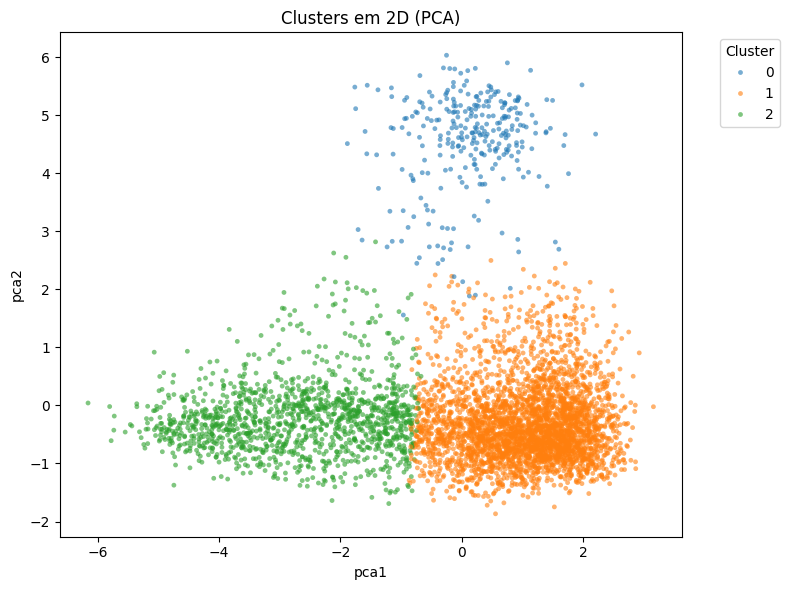

In [13]:
from sklearn.decomposition import PCA

sample_viz = df_features.sample(n=min(5000, len(df_features)), random_state=42)
X_viz = sample_viz[numeric_cols]
X_viz_scaled = scaler.transform(X_viz)

pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X_viz_scaled)

sample_viz = sample_viz.assign(pca1=pca_coords[:,0], pca2=pca_coords[:,1])

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=sample_viz,
    x='pca1', y='pca2', hue='cluster',
    palette='tab10', s=12, alpha=0.6, linewidth=0
)
plt.title('Clusters em 2D (PCA)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 7. Amostras por cluster
    Útil para rotular clusters manualmente.

In [14]:
# Amostras variadas por cluster: top populares + aleatórias + menos populares
rows = []
for cid, g in df_features.groupby('cluster'):
    top = g.nlargest(2, 'popularity')
    rand = g.sample(n=min(3, len(g)), random_state=123)
    low = g.nsmallest(1, 'popularity')
    dedup_cols = ['track_id'] if 'track_id' in g.columns else ['artist_name','track_name','genre']
    chunk = pd.concat([top, rand, low]).drop_duplicates(subset=dedup_cols)
    chunk['cluster'] = cid
    rows.append(chunk)

sample_mix = pd.concat(rows)
sample_mix[['cluster','artist_name','track_name','genre','popularity']]


,cluster,artist_name,track_name,genre,popularity
87125,0,XXXTENTACION,Carry On,Rap,80
67053,0,XXXTENTACION,Train food,Hip-Hop,72
74794,0,Children Songs Company,Santa Claus,Children's Music,0
172198,0,Craig Ferguson,Weird Hollywood Ideas,Comedy,19
174351,0,Bill Hicks,I Love My Job (Live),Comedy,17
15,0,Michel Roux,Les aventures d'Arsène Lupin: 813 - Partie 6,Movie,0
9027,1,Ariana Grande,7 rings,Dance,100
9026,1,Ariana Grande,"break up with your girlfriend, i'm bored",Dance,99
60910,1,Rels B,Buenos Genes,R&B,73
5069,1,Nothing More,Here's To The Heartache,Alternative,50


In [15]:
# Top faixas mais populares por cluster (ordem decrescente de popularidade)
top_by_pop = (
    df_features.sort_values('popularity', ascending=False)
    .groupby('cluster')
    .head(5)
)
top_by_pop[['cluster', 'artist_name', 'track_name', 'genre', 'popularity']]


,cluster,artist_name,track_name,genre,popularity
9027,1,Ariana Grande,7 rings,Dance,100
9026,1,Ariana Grande,"break up with your girlfriend, i'm bored",Dance,99
86951,1,Post Malone,Wow.,Rap,99
66643,1,Daddy Yankee,Con Calma,Hip-Hop,98
86953,1,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,Rap,97
9029,2,Ariana Grande,needy,Dance,92
86989,2,XXXTENTACION,changes,Rap,88
107896,2,Billie Eilish,ocean eyes,Pop,86
191939,2,John Legend,All of Me,Soul,85
77054,2,H.E.R.,Best Part (feat. Daniel Caesar),Children’s Music,84
